#Introduction#
In this tutorial, we demonstrate how to use the Quantum Approximate Optimization Algorithm (QAOA) to perform sparse signal reconstruction by selecting a subset of Fourier coefficients. We consider a signal with $N=20$ Fourier coefficients and aim to pick the best $K=5$ coefficients that minimize the reconstruction error. This problem is formulated as a combinatorial optimization: we want to maximize the energy captured by the selected coefficients (equivalently minimize the error from the discarded ones). We will map this task to a Quadratic Unconstrained Binary Optimization (QUBO) problem and then solve it using QAOA on a quantum simulator. The notebook follows a format similar to IBM's QAOA tutorial, including explanatory text, code, and visualizations.
#Steps Overview:#
Define a test signal and compute its Fourier coefficients.
Formulate the selection problem as a QUBO with an objective (reconstruction error) and a $K$-hot constraint (exactly $K$ coefficients must be selected).
Use Qiskit’s optimization module to construct a QuadraticProgram for the QUBO.
Set up the QAOA algorithm with a suitable quantum backend (AerSimulator) and classical optimizer.
Solve the QUBO using QAOA and retrieve the selected indices and the minimized cost (error).
Visualize the selected coefficients in the frequency domain and compare the reconstructed signal (using the selected Fourier components) to the original signal.

##Installation##

In [ ]:
!pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit-optimization qiskit-ibmq-provider


In [ ]:
!pip install "qiskit==0.43.1" "qiskit-aer==0.12.0" "qiskit-optimization==0.5.0" --quiet



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 

In [ ]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import matplotlib.pyplot as plt


algorithm_globals.random_seed = 42


#Problem Setup: Sparse Signal and Fourier Coefficients#
We first create a synthetic signal with known Fourier coefficients. For clarity, we construct a signal that has a few dominant frequency components so that an optimal choice of $K=5$ coefficients is well-defined. In a real scenario, these coefficients would come from the Fourier transform of some signal. Here, we will:
Define $N = 20$ as the total number of Fourier coefficients.
Choose a handful of frequencies to have significant amplitudes (to simulate a signal with sparse frequency content), and set the rest to near-zero.
Compute the Fourier coefficients array $c_n$ (complex values). The magnitude squared $|c_n|^2$ represents the energy of the signal at frequency index $n$.
Our goal will be to select the 5 indices corresponding to the largest $|c_n|^2$ values, since that intuitively minimizes the error if we reconstruct using only those frequencies.

In [ ]:
N = 20
K = 5

c = np.zeros(N, dtype=complex)

signif_freqs = [1, 9, 17, 19]
amplitudes = [0.85, 0.83, 0.79, 0.78]
phases = np.random.uniform(0, 2*np.pi, len(signif_freqs))


for freq, amp, phi in zip(signif_freqs, amplitudes, phases):
    c[freq] = amp * np.exp(1j * phi)
    c[N - freq] = amp * np.exp(-1j * phi)

c[0] = 0.0
if N % 2 == 0:
    c[N//2] = 0.0

power = np.abs(c)**2
print("Non-zero coefficient magnitudes: ", power[power > 1e-8])


Non-zero coefficient magnitudes:  [0.6084 0.6241 0.6889 0.6889 0.6241 0.6084]


In this setup, we explicitly created 4 pairs of significant frequencies (and their complex conjugates), for a total of 8 indices with non-negligible values in c. All other coefficients remain zero. The printed output will show the magnitudes squared of the non-zero coefficients, which should correspond to the chosen amplitudes squared (for example, around 0.85², 0.83², etc.). These coefficients represent our "original" frequency spectrum. Next, we formulate the optimization problem to pick $K=5$ of these indices that minimize the reconstruction error. The reconstruction error, if we drop certain coefficients, is the sum of $|c_n|^2$ for all unselected frequencies (because that energy is lost in the reconstructed signal).

#QUBO Formulation: Objective and Constraints#
To apply QAOA, we need to express the problem as a QUBO (Quadratic Unconstrained Binary Optimization). We introduce a binary decision variable $x_n$ for each frequency index $n$, where:
- $x_n = 1$ if coefficient $n$ is selected in the reconstruction,
- $x_n = 0$ if coefficient $n$ is not selected.

**Objective (Error Term)**: We want to minimize the total reconstruction error. If coefficient $n$ (with power $|c_n|^2$) is not selected ($x_n=0$), it contributes $|c_n|^2$ to the error; if it is selected ($x_n=1$), it contributes no error. We can write the error as:

$$E_{error} = \sum_{n=0}^{N-1} (1-x_n)|c_n|^2,$$

 ,
which expands to $\sum_{n} |c_n|^2 - \sum_{n} x_n |c_n|^2$. The first term $\sum_n |c_n|^2$ is a constant (the total signal energy), so minimizing $E_{\text{error}}$ is equivalent to maximizing the second term $\sum_n x_n |c_n|^2$ (the energy retained by the selected coefficients). Constraint ($K$-hot): We must select exactly $K$ coefficients out of $N$. This is an equality constraint on the binary variables:

$$E_{error} = \sum_{n=0}^{N-1} x_n = K,$$

This is sometimes called a "$K$-hot" constraint (a generalization of a one-hot constraint). To form a QUBO, we incorporate the constraint into the objective (e.g., via a penalty method). However, Qiskit’s optimization module allows us to handle the constraint explicitly and will convert the problem to a QUBO automatically. Essentially, the constrained problem can be transformed into an unconstrained QUBO:
$$E_{error} = \sum_{n=0}^{N-1} (1-x_n)|c_n|^2 + \lambda(\sum_n x_n-K)^2,$$

where $\lambda$ is a large penalty weight ensuring the $K$-hot condition is satisfied in the optimal solution
docs.quantum.ibm.com
. The QUBO term $(\sum_n x_n - K)^2$ expands into quadratic pairwise interactions $2\lambda, x_i x_j$ and linear terms $-!2\lambda K, x_n$, enforcing the selection count. We will let Qiskit choose an appropriate penalty $\lambda$ automatically.

- Define $N$ binary variables $x_0, x_1, \dots, x_{49}$.
- Set the objective to maximize $\sum_n |c_n|^2 x_n$ (which is equivalent to minimizing error).
- Add a linear equality constraint $\sum_n x_n = K$.

In [ ]:
qp = QuadraticProgram("Fourier_selection")

for i in range(N):
    qp.binary_var(name=f"x{i}")

w = power
objective_linear = {f"x{i}": float(w[i]) for i in range(N)}
qp.maximize(linear=objective_linear)

constraint_coeffs = {f"x{i}": 1.0 for i in range(N)}
qp.linear_constraint(linear=constraint_coeffs, sense='==', rhs=K, name="K_hot_constraint")

print("Optimization problem formulation:")
print(qp.prettyprint())


Optimization problem formulation:
Problem name: Fourier_selection

Maximize
  0.6084*x1 + 0.6889*x11 + 0.6241000000000001*x17 + 0.6084*x19
  + 0.6241000000000001*x3 + 0.6889*x9

Subject to
  Linear constraints (1)
    x0 + x1 + x10 + x11 + x12 + x13 + x14 + x15 + x16 + x17 + x18 + x19 + x2
    + x3 + x4 + x5 + x6 + x7 + x8 + x9 == 5  'K_hot_constraint'

  Binary variables (20)
    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12 x13 x14 x15 x16 x17 x18 x19



Running the above will print a summary of the optimization problem. We expect to see:
- The objective function: a linear combination of the $x_i$ variables with coefficients equal to $|c_i|^2$. (Because we used maximize, it will show as maximizing that linear combination.)
- One linear constraint enforcing exactly 5 of the $x_i$ are 1.

At this point, we have formulated the selection problem for QAOA. Next, we will solve it using the QAOA algorithm.

#Running QAOA on the QUBO#
**Setting up the QAOA solver:** QAOA is a hybrid quantum-classical algorithm that uses a parameterized quantum circuit to represent the solution space and a classical optimizer to tweak the circuit parameters to minimize the problem Hamiltonian. In Qiskit, we use MinimumEigenOptimizer as a high-level wrapper to solve the QuadraticProgram with a chosen quantum algorithm (QAOA in this case). We will use the Aer simulator backend to run the quantum circuits.
Key configurations for QAOA:
- ***Backend:*** We use Aer.get_backend('aer_simulator') for shot-based simulation of the quantum circuit. This simulates a realistic scenario (measuring qubits in the computational basis).
- ***Optimizer:*** We choose COBYLA (a gradient-free optimizer) for simplicity, with a limited number of iterations. This will tune the QAOA parameters.
- ***QAOA circuit depth (reps):*** We choose a small depth (e.g. $p=2$) which means the QAOA ansatz will have 2 alternating layers of the problem Hamiltonian and mixing Hamiltonian. Increasing this depth can improve result quality at the cost of longer circuits.
- ***Initial parameters:*** Not specified here, so Qiskit will initialize them (often zero or random). We set a random seed above to ensure reproducibility of any random initialization.

In [ ]:
backend = Aer.get_backend('aer_simulator')

p = 2
optimizer = COBYLA(maxiter=50)

qaoa = QAOA(reps=p, optimizer=optimizer, quantum_instance=QuantumInstance(backend, shots=1024))
qaoa_solver = MinimumEigenOptimizer(qaoa)

result = qaoa_solver.solve(qp)

selected_indices = [i for i, v in enumerate(result.x) if v == 1]
retained_energy = sum(w[selected_indices])
reconstruction_error = sum(w) - retained_energy

print("Selected coefficient indices:", selected_indices)
print("Objective value (sum of selected |c_n|^2):", result.fval)
print("Reconstruction error (cost):", reconstruction_error)


<ipython-input-7-f7419e409266>:6: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qaoa = QAOA(reps=p, optimizer=optimizer, quantum_instance=QuantumInstance(backend, shots=1024))
<ipython-input-7-f7419e409266>:6: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(reps=p, optimizer=optimizer, quantum_instance=QuantumInstance(backend, shots=1024))


Selected coefficient indices: [3, 9, 11, 17, 19]
Objective value (sum of selected |c_n|^2): 3.2344000000000004
Reconstruction error (cost): 0.6083999999999996


In [ ]:
# Parameters for reconstruction
Kt = 100
t = np.linspace(0, 1, Kt)
ω0 = 2 * np.pi
x_full = np.array([
    np.sum([c[n] * np.exp(1j * n * ω0 * tk) for n in range(len(c))])
    for tk in t
])


x_sparse = np.array([
    np.sum([c[n] * np.exp(1j * n * ω0 * tk) if n in selected_indices else 0 for n in range(len(c))])
    for tk in t
])


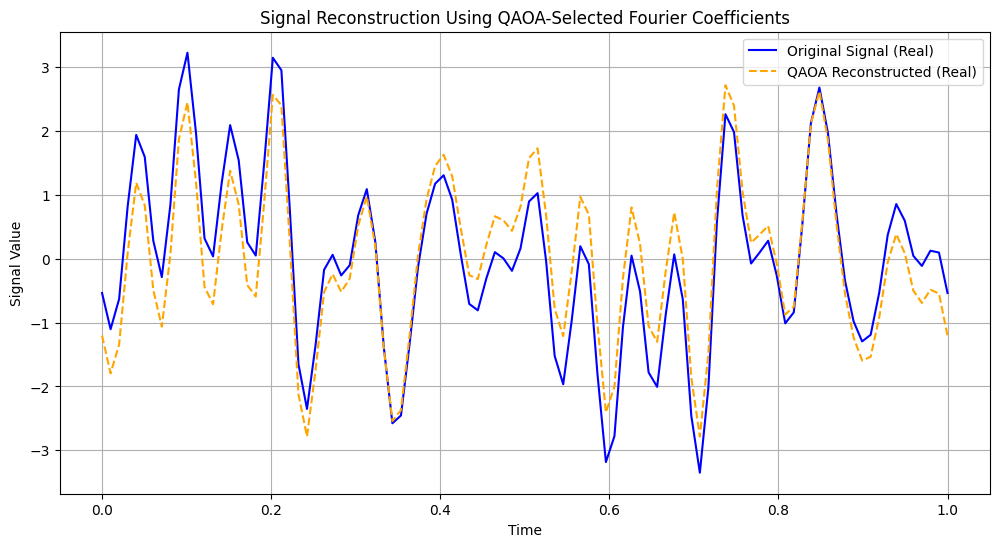

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t, x_full.real, label='Original Signal (Real)', color='blue')
plt.plot(t, x_sparse.real, '--', label='QAOA Reconstructed (Real)', color='orange')
plt.title('Signal Reconstruction Using QAOA-Selected Fourier Coefficients')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()


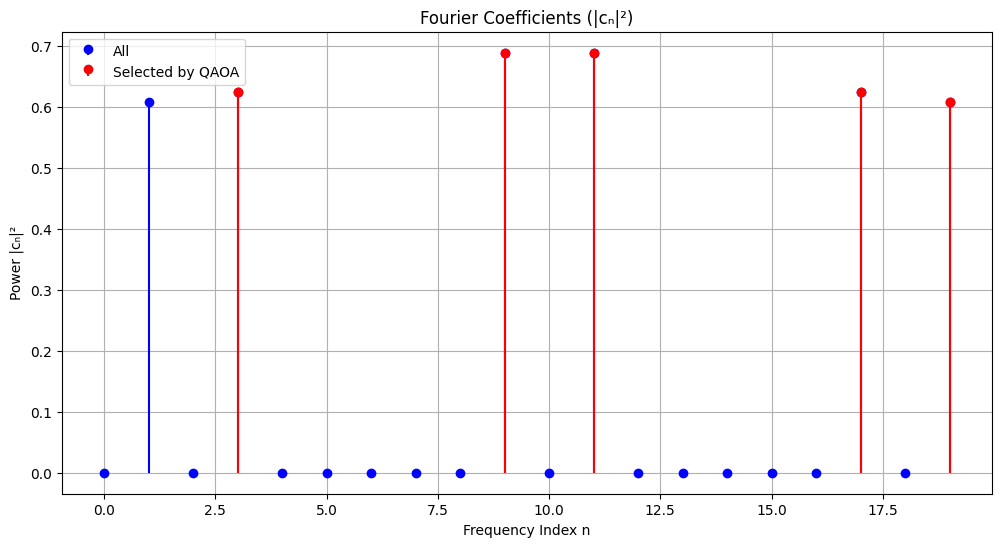

In [ ]:
power = np.abs(c)**2

plt.figure(figsize=(12, 6))
plt.stem(range(len(power)), power, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.stem(selected_indices, power[selected_indices], linefmt='r-', markerfmt='ro', basefmt=" ")
plt.title('Fourier Coefficients (|cₙ|²)')
plt.xlabel('Frequency Index n')
plt.ylabel('Power |cₙ|²')
plt.legend(['All', 'Selected by QAOA'])
plt.grid(True)
plt.show()


In [ ]:
mse_list = []
sparsity_list = []

for K in range(1, N + 1):
    qp = QuadraticProgram("Fourier_selection")
    for i in range(N):
        qp.binary_var(name=f"x{i}")
    objective_linear = {f"x{i}": float(power[i]) for i in range(N)}
    qp.maximize(linear=objective_linear)
    constraint_coeffs = {f"x{i}": 1.0 for i in range(N)}
    qp.linear_constraint(linear=constraint_coeffs, sense='==', rhs=K, name="K_hot_constraint")

    qaoa = QAOA(reps=2, optimizer=COBYLA(maxiter=50), quantum_instance=QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024))
    qaoa_solver = MinimumEigenOptimizer(qaoa)
    result = qaoa_solver.solve(qp)

    selected_indices = [i for i, v in enumerate(result.x) if v == 1]

    x_sparse = np.array([
        np.sum([c[n] * np.exp(1j * n * ω0 * tk) if n in selected_indices else 0 for n in range(N)])
        for tk in t
    ])

    mse = np.mean(np.abs(x_full - x_sparse)**2)
    mse_list.append(mse)
    sparsity_list.append(K)


<ipython-input-11-609b5755b582>:13: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qaoa = QAOA(reps=2, optimizer=COBYLA(maxiter=50), quantum_instance=QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024))
<ipython-input-11-609b5755b582>:13: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(reps=2, optimizer=COBYLA(maxiter=50), quantum_instance=QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024))
<ipython-input-11-609b5755b582>:13: DeprecationWarning: The class ``qiskit.utils.quan

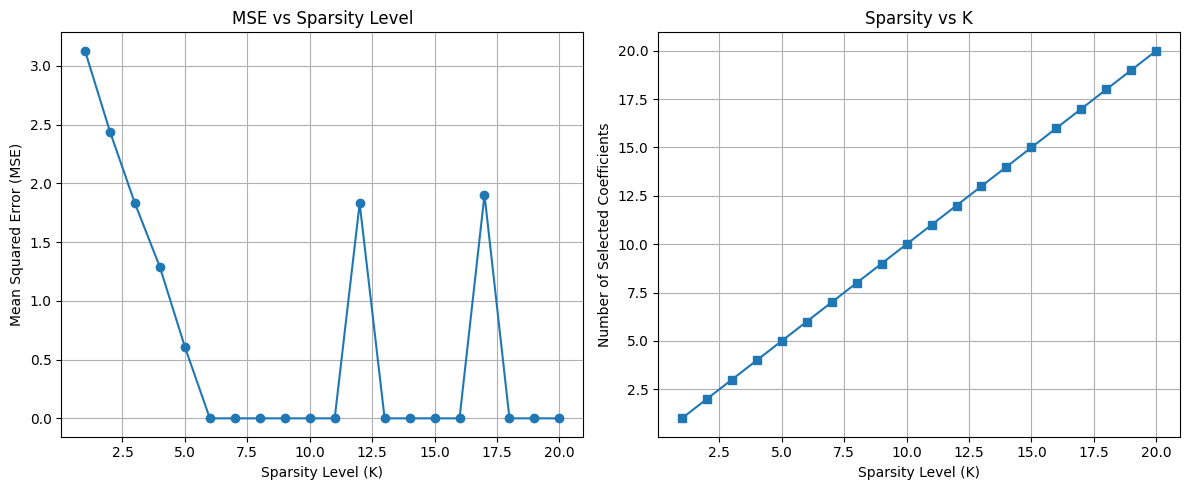

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sparsity_list, mse_list, marker='o')
plt.xlabel('Sparsity Level (K)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Sparsity Level')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sparsity_list, sparsity_list, marker='s')
plt.xlabel('Sparsity Level (K)')
plt.ylabel('Number of Selected Coefficients')
plt.title('Sparsity vs K')
plt.grid(True)

plt.tight_layout()
plt.show()
